In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import sinter
import matplotlib.pyplot as plt
import os

from qecdec import RotatedSurfaceCode_Memory
from qecdec import BPDecoder, SinterDecoderWrapper

In [2]:
d_list = [5, 7, 9, 11]
p = 0.005
scaling_factor_list = np.arange(0, 1.0001, 0.05).tolist()
max_iter = 50

In [3]:
def generate_sinter_tasks_and_custom_decoders():
    tasks: list[sinter.Task] = []
    custom_decoders: dict[str, sinter.Decoder] = {}
    for d in d_list:
        # Setup the experiment.
        expmt = RotatedSurfaceCode_Memory(
            d=d,
            rounds=d,
            basis='Z',
            data_qubit_error_rate=p,
            meas_error_rate=p,
        )
        for scaling_factor in scaling_factor_list:
            # Setup a sinter.Task with BP decoder.
            bp = BPDecoder(expmt.chkmat, expmt.prior, max_iter=max_iter, scaling_factor=scaling_factor)
            custom_decoder_id = f"custom_decoder_{len(custom_decoders)}"
            custom_decoders[custom_decoder_id] = SinterDecoderWrapper(bp, expmt.obsmat)
            tasks.append(sinter.Task(
                circuit=expmt.circuit,
                detector_error_model=expmt.dem,
                decoder=custom_decoder_id,
                json_metadata={'d': d, 'scaling_factor': scaling_factor},
            ))
    return tasks, custom_decoders

tasks, custom_decoders = generate_sinter_tasks_and_custom_decoders()


In [4]:
sinter_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    custom_decoders=custom_decoders,
    print_progress=True,
)

Starting 7 workers...
84 tasks left:
  workers           decoder eta shots_left errors_left json_metadata                         
        1  custom_decoder_0   ?   10000000         100 d=5,scaling_factor=0.0                
        1  custom_decoder_1   ?   10000000         100 d=5,scaling_factor=0.05               
        1  custom_decoder_2   ?   10000000         100 d=5,scaling_factor=0.1                
        1  custom_decoder_3   ?   10000000         100 d=5,scaling_factor=0.15000000000000002
        1  custom_decoder_4   ?   10000000         100 d=5,scaling_factor=0.2                
        1  custom_decoder_5   ?   10000000         100 d=5,scaling_factor=0.25               
        1  custom_decoder_6 <1m    9999727          74 d=5,scaling_factor=0.30000000000000004
        0  custom_decoder_7 ?·∞   10000000         100 d=5,scaling_factor=0.35000000000000003
        0  custom_decoder_8 ?·∞   10000000         100 d=5,scaling_factor=0.4                
        0  custom_decod

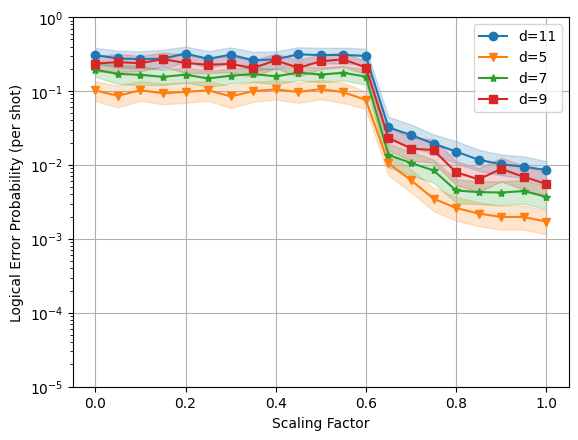

In [5]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=sinter_stats,
    group_func=lambda stat: f"d={stat.json_metadata['d']}",
    x_func=lambda stat: stat.json_metadata['scaling_factor'],
)
ax.semilogy()
ax.set_ylim(1e-5, 1)
ax.grid()
ax.set_ylabel('Logical Error Probability (per shot)')
ax.set_xlabel('Scaling Factor')
ax.legend()